In [1]:
# Krystian Chmura
YEAR = "2017"

In [2]:
import glob
import json
import pathlib
import sys
import re
from decimal import *
import matplotlib.pyplot as plt
import numpy as np

In [3]:
def read_judgments_jsons(files):
    for path in files:
        yield json.loads(pathlib.Path(path).read_text())

def items_from_judgments_jsons(judgments):
    for judgment in judgments:
        for item in judgment["items"]:
            yield item

def is_correct_judgment_year(year):
    return lambda item:item["judgmentDate"][:4] == year

def items_in_given_year(files):
    judgments_jsons = read_judgments_jsons(files)
    items = items_from_judgments_jsons(judgments_jsons)
    for item in filter(is_correct_judgment_year(YEAR), items):
        yield item
            
def text_contents_in_given_year(files):
    for item in items_in_given_year(files):
        yield item["textContent"]

In [4]:
def get_multiplier(expression):
    word_to_multiplier_tuples = {
        ("tysiąc", "tysiące", "tysiąca", "tysięcy", "tys", "tys."): 10**3,
        ("milion", "miliony", "miliona", "milionów", "mln" , "mln."): 10**6,
        ("miliard", "miliardy", "miliarda", "miliardów", "mld", "mld."): 10**9
    }
    word_to_multiplier = {
        word: multiplier
        for tup, multiplier in word_to_multiplier_tuples.items()
        for word in tup
    }

    for current_word in word_to_multiplier:
        if re.search("{}".format(current_word), expression):
            return word_to_multiplier[current_word]

    return 1

def extract_money_amounts_from_text(text):
    number_catch_group = r"(\d[\d,\.\s]*)"
    potential_multiplier = r"(\s\w+\s)?"
    round_brackets = r"(\([^\)]*?\))?"

    regex = r"{number_catch_group}\s*?{potential_multiplier}\s*?{round_brackets}\s*?{potential_multiplier}\s*?zł".format(
        number_catch_group=number_catch_group,
        potential_multiplier=potential_multiplier,
        round_brackets=round_brackets
    )

    for match in re.finditer(regex, text):
        try:
            if match.group(0).find("starych") != -1:
                continue

            number = match.group(1)

            # remove unecessary dots
            number = number.replace(".", "")

            # convert polish ',' decimal seperator to english
            number = number.replace(",", ".")

            # remove whitespaces between digits
            number = re.sub(r"\s", "", number)
            dec = Decimal(number)

            m = match.group(0)
            m = re.sub("\(.*?\)", "", m)
            
            multiplier = get_multiplier(m)
            money_amount = int(dec * multiplier)

            if money_amount > 10**14:
                continue

            yield money_amount
        except Exception as e:
            pass

In [5]:
files = glob.glob("data/json/judgments*.json")
print(len(files))

3173


In [6]:
judgments_jsons = read_judgments_jsons(files)
items = items_from_judgments_jsons(judgments_jsons)

money_amounts = []

for text_content in text_contents_in_given_year(files):
    money_amounts.extend(extract_money_amounts_from_text(text_content))

print(len(money_amounts))

694704


In [15]:
def show_histogram(name, data, bins):
    plt.figure(figsize=(16, 9))
    plt.hist(data, bins)
    plt.gca().set_xscale("log")

    plt.title(name)
    plt.xlabel("Money values")
    plt.ylabel("Occurrences")
    plt.grid(True)
    plt.show()

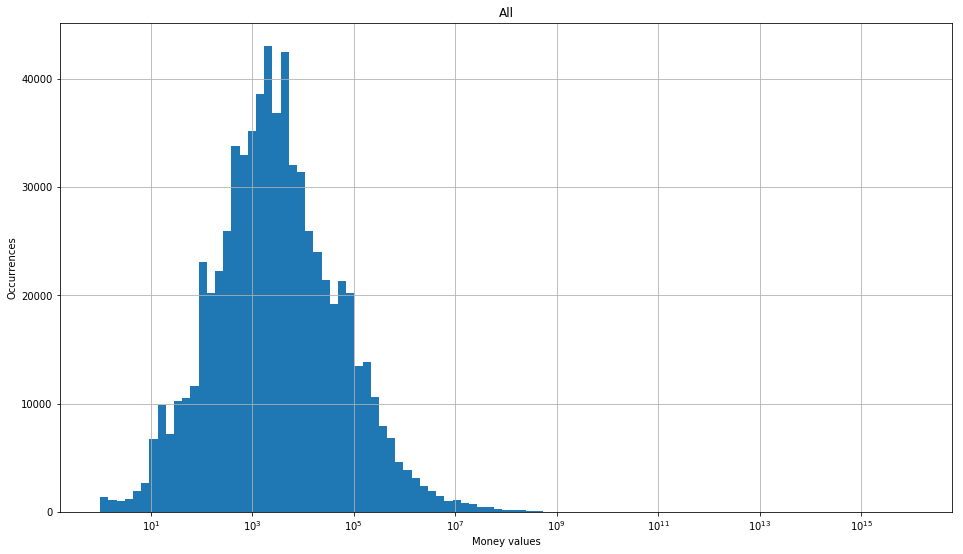

In [16]:
# 1
show_histogram("All", money_amounts, bins=np.logspace(0, 16, 100))

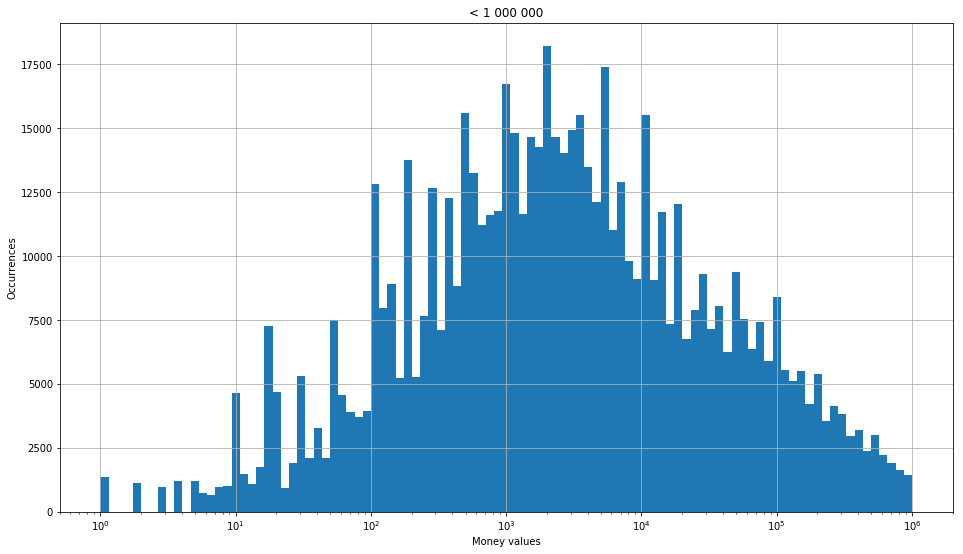

In [17]:
# 2
show_histogram("< 1 000 000",
               [x for x in money_amounts if x < 10**6],
               bins=np.logspace(0, 6, 100))

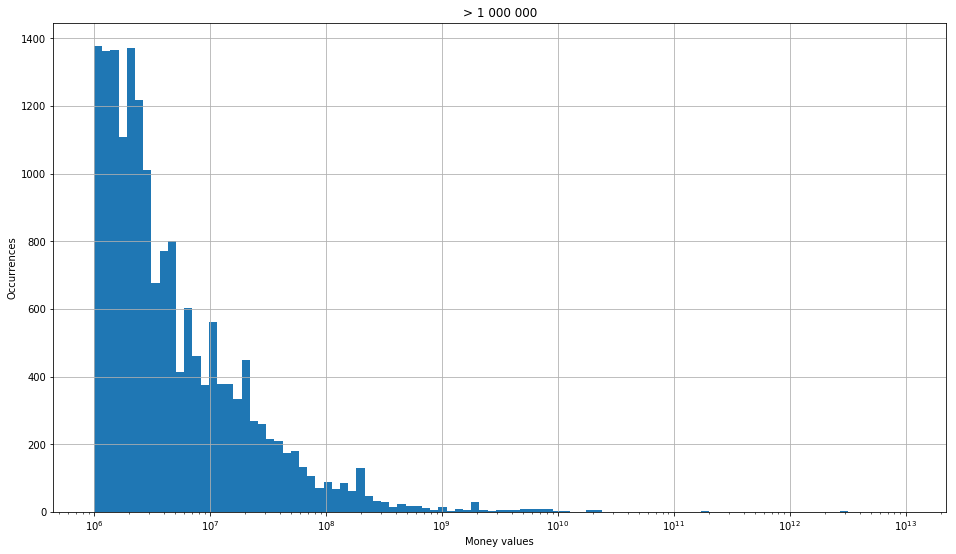

In [18]:
# 2
show_histogram("> 1 000 000", 
               [x for x in money_amounts if x > 10**6],
               bins=np.logspace(6, 13, 100))

In [11]:
def is_any_referenced_regulation_matched(referenced_regulations):
    for referenced_regulation in referenced_regulations:
        text = referenced_regulation["text"].lower()
        phrazes = ("kodeks", "cywiln", "445", "23 kwietnia 1964 r")
        if all([re.search(phraze, text) for phraze in phrazes]):
            return True
    return False

number_of_judgments = 0
number_of_judgments_containing_given_regulation = 0

for item in items_in_given_year(files):
    number_of_judgments += 1
    if is_any_referenced_regulation_matched(item["referencedRegulations"]):
        number_of_judgments_containing_given_regulation += 1
    
percentage = (100.0 * number_of_judgments_containing_given_regulation) / number_of_judgments

# 3
print(r"{} / {} == {:.2f}%".format(
    number_of_judgments_containing_given_regulation, 
    number_of_judgments,
    percentage ))

1895 / 44719 == 4.24%


In [14]:
number_of_judgments = 0
number_of_judgments_containing_given_word = 0

word_forms = (
    "szkoda", 
    "szkodą", 
    "szkodę", 
    "szkodo", 
    "szkody", 
    "szkodzie", 
    "szkodach", 
    "szkodami", 
    "szkodom", 
    "szkód"
)

word_forms = [r'\b' + x + r'\b' for x in word_forms]
    
for text_content in text_contents_in_given_year(files):
    number_of_judgments += 1

    if re.search("|".join(word_forms), text_content):
        number_of_judgments_containing_given_word += 1
    
percentage = (100.0 * number_of_judgments_containing_given_word) / number_of_judgments

# 4
print(r"{} / {} == {:.2f}%".format(
    number_of_judgments_containing_given_word, 
    number_of_judgments,
    percentage ))


14036 / 44719 == 31.39%
